## Construct a SOFR curve and value an IRS

This notebook illustrates how a SOFR curve can be calibrated against input instruments, then used to price and risk an interest rate swap.

All code taken from https://rateslib.readthedocs.io/en/1.1.x/z_swpm.html


In [35]:
# Install rateslib if running on pyodide.
import platform
if platform.system() == 'Emscripten':
    import micropip
    await micropip.install('rateslib')
    package_list = micropip.list()
    package_list["rateslib"]
    

We first set-up the market data inputs.

In [1]:
from datetime import datetime as dt
import pandas as pd
import rateslib as rl

as_of_date = dt(2023, 8, 17)
effective_date = rl.add_tenor(as_of_date, "2b", "F", "nyc")

data = pd.DataFrame({
    "Term": ["1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M", "6M", "7M", "8M", "9M", "10M", "11M", "12M", "18M", "2Y", "3Y", "4Y"],
    "Rate": [5.30111, 5.30424, 5.30657, 5.31100, 5.34800, 5.38025, 5.40915, 5.43078, 5.44235, 5.44950, 5.44878, 5.44100, 5.42730, 5.40747, 5.3839, 5.09195, 4.85785, 4.51845, 4.31705],
})
data["Termination"] = [rl.add_tenor(effective_date, tenor, "F", "nyc") for tenor in data["Term"]]
data


,Term,Rate,Termination
0,1W,5.30111,2023-08-28
1,2W,5.30424,2023-09-05
2,3W,5.30657,2023-09-11
3,1M,5.31100,2023-09-21
4,2M,5.34800,2023-10-23
5,3M,5.38025,2023-11-21
6,4M,5.40915,2023-12-21
7,5M,5.43078,2024-01-22
8,6M,5.44235,2024-02-21
9,7M,5.44950,2024-03-21


A visual representation of the inputs.

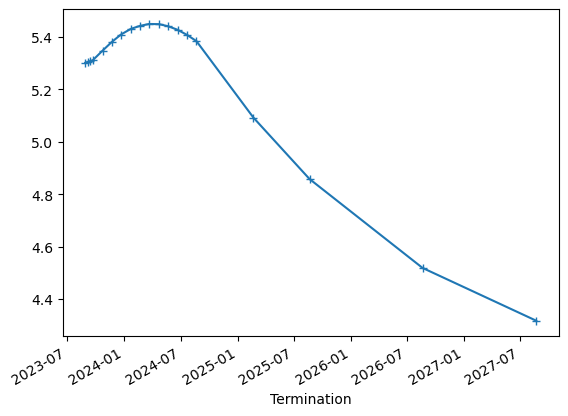

In [20]:
pd.Series(data.Rate.values, data.Termination).plot(style='+-');


### Curve structure

We create a curve with node dates matching the inputs, give the interpolation information.

In [21]:
sofr_curve = rl.Curve(
    id="sofr_curve",
    convention="Act360",
    calendar="nyc",
    modifier="MF",
    interpolation="log_linear",
    nodes={
        **{as_of_date: 1.0},  # <- this is today's DF,
        **{term_dt.to_pydatetime(): 1.0 for term_dt in data["Termination"]},
    }
)
sofr_curve


### Create a Solver

Calibrate the curve to the input instruments using a Solver.

In [29]:
instruments = [
    rl.IRS(termination=term.to_pydatetime(), 
        effective=effective_date,
        spec="usd_irs",
        curves="sofr_curve"
       ) for term in data["Termination"]
]

solver = rl.Solver(
    curves=[sofr_curve],
    instruments=instruments,
    s=data["Rate"],
    instrument_labels=data["Term"],
    id="us_rates",
)

SUCCESS: `func_tol` reached after 5 iterations (levenberg_marquardt) , `f_val`: 3.116744256634176e-17, `time`: 0.0655s


### Curve results

Can now read the discount factors from the calibrated curve.

In [34]:
data["DF"] = [float(sofr_curve[term]) for term in data["Termination"]]
data

,Term,Rate,Termination,DF
0,1W,5.30111,2023-08-28,0.998382
1,2W,5.30424,2023-09-05,0.997208
2,3W,5.30657,2023-09-11,0.996327
3,1M,5.31100,2023-09-21,0.994862
4,2M,5.34800,2023-10-23,0.990145
5,3M,5.38025,2023-11-21,0.985856
6,4M,5.40915,2023-12-21,0.981421
7,5M,5.43078,2024-01-22,0.976721
8,6M,5.44235,2024-02-21,0.972364
9,7M,5.44950,2024-03-21,0.968194


### Pricing an Instrument

We create an Interest Rate Swap to price.

In [7]:
irs = rl.IRS(
    effective=dt(2023, 11, 21),
    termination=dt(2025, 2, 21),
    notional=-100e6,
    fixed_rate=5.40,
    curves="sofr_curve",
    spec="usd_irs",
)


Then use the solver to price it.

In [8]:
pv = irs.npv(solver=solver)
pv.real

456622.09860395174

### Delta

The solver can now be used to get delta senstivites,

In [9]:
delta = irs.delta(solver=solver)
delta

local_ccy                            usd
display_ccy                          usd
type        solver   label              
instruments us_rates 1W    -5.068355e-01
                     2W     4.448341e-14
                     3W     3.262071e-13
                     1M    -6.819837e-13
                     2M     6.608491e-13
                     3M     2.484503e+03
                     4M     2.835389e-13
                     5M    -1.242682e-12
                     6M     6.003902e+01
                     7M    -6.609346e-01
                     8M     9.208455e-13
                     9M    -2.533433e-12
                     10M   -1.728135e-12
                     11M   -1.077498e-12
                     12M    3.042953e-02
                     18M   -1.442208e+04
                     2Y    -1.265049e+00
                     3Y     1.130177e-04
                     4Y    -1.172195e-08

Show the strip delta graphically.

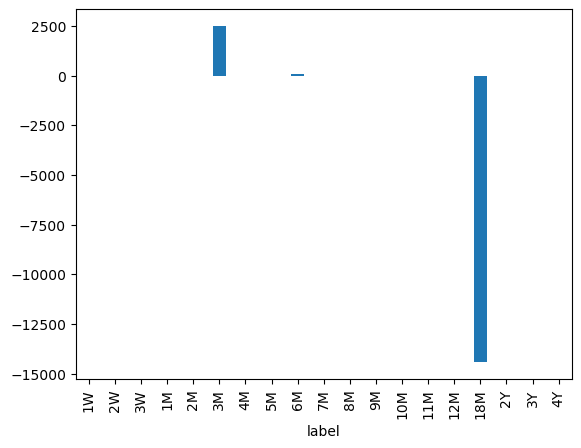

In [10]:
ccy_delta = delta["usd"]["usd"]
pd.Series(ccy_delta.values,
          ccy_delta.index.get_level_values("label")).plot.bar();

In [11]:
float(ccy_delta.sum())


-11879.936804971858

In [12]:
irs.analytic_delta(curve=sofr_curve).real


-11896.00857729232

### Gamma

The solver can also be used to get cross-gamma sensitivities.

In [13]:
irs.gamma(solver=solver).sum().sum()


np.float64(3.176665278863453)

### Cashflows

Show a summary of cashflows to be paid, or get a more detailed breakdown of cashflow information.

In [14]:
irs.cashflows_table(solver=solver)


local_ccy,USD
collateral_ccy,NaN
payment,
2024-02-23,-7613.744059
2025-02-25,501239.067003


In [15]:
irs.cashflows(solver=solver)


Type   Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod     Stub  USD 2023-11-21 2024-02-21 2024-02-23     act360   
     1  FixedPeriod  Regular  USD 2024-02-21 2025-02-21 2025-02-25     act360   
leg2 0  FloatPeriod     Stub  USD 2023-11-21 2024-02-21 2024-02-23     act360   
     1  FloatPeriod  Regular  USD 2024-02-21 2025-02-21 2025-02-25     act360   

             DCF     Notional        DF Collateral      Rate  Spread  \
leg1 0  0.255556 -100000000.0  0.972076       None  5.400000     NaN   
     1  1.016667 -100000000.0  0.925752       None  5.400000     NaN   
leg2 0  0.255556  100000000.0  0.972076       None  5.429793     0.0   
     1  1.016667  100000000.0  0.925752       None  4.906978     0.0   

            Cashflow           NPV  FX Rate       NPV Ccy  
leg1 0  1.380000e+06  1.341464e+06      1.0  1.341464e+06  
     1  5.490000e+06  5.082380e+06      1.0  5.082380e+06  
leg2 0 -1.387614e+06 -1.348865e+06      1.0 -1.348865e+06  
     1 -4.988761e+06 -4.618357e+06      1.0 -4.618357e+06